## Data Cleaning

Let us start by importing all necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.losses import MAPE
from keras.losses import mse
from keras.optimizers import Adam

Let us reading the given CSV file

In [ ]:
df = pd.read_excel("data.xlsx")

df

,Date,No_of_calls_from_commercial_card,No_of_calls_from_retail_card,No_of_calls_from_student_card
0,2017-01-01,264.0,403.0,860.0
1,2017-01-02,528.0,792.0,1681.0
2,2017-01-03,2505.0,3774.0,7639.0
3,2017-01-04,2145.0,3236.0,6513.0
4,2017-01-05,2164.0,3265.0,6604.0
...,...,...,...,...
1668,2021-07-27,NaN,NaN,NaN
1669,2021-07-28,NaN,NaN,NaN
1670,2021-07-29,NaN,NaN,NaN
1671,2021-07-30,NaN,NaN,NaN


From the problem statement, we know that the values given for the first year are accurate and the rest of the given values are scrambled. So we will first look at the accurate values

In [ ]:
commercial_card_accurate = df['No_of_calls_from_commercial_card'][:365]
retail_card_accurate = df['No_of_calls_from_retail_card'][:365]
student_card_accurate = df['No_of_calls_from_student_card'][:365]

date = df['Date']

Let us now observe the trend of these values over a small range, let us say the first 21 values (3 weeks)

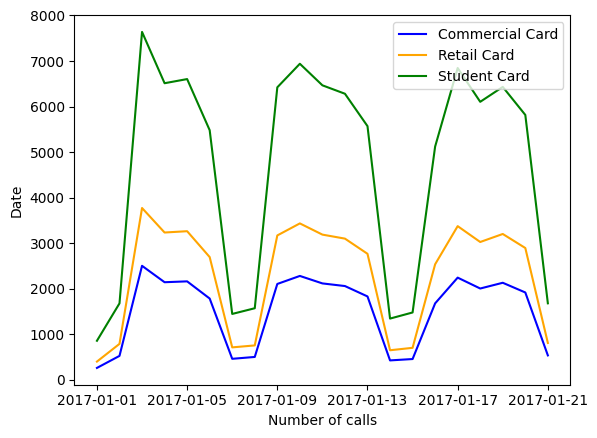

In [ ]:
x_axis = date[:21]
y_axis1 = commercial_card_accurate[:21]
y_axis2 = retail_card_accurate[:21]
y_axis3 = student_card_accurate[:21]

plt.plot(x_axis, y_axis1, color='blue', label='Commercial Card')
plt.plot(x_axis, y_axis2, color='orange', label='Retail Card')
plt.plot(x_axis, y_axis3, color='green', label='Student Card')

plt.xlabel('Number of calls')
plt.ylabel('Date')
plt.legend()

plt.show()

The first thing that we can observe from the graph is that the number of calls for student cards > number of calls for retail cards > number of cards for commercial calls

To verify this, let us check if this trend is valid throughout the dataset

In [ ]:
#to verify that retail card>retail card>student card

i=0
for i in range (365):
    if (student_card_accurate[i]<retail_card_accurate[i] or student_card_accurate[i]<commercial_card_accurate[i] or retail_card_accurate[i]<commercial_card_accurate[i]):
        print(i)

Since no output was generated, this means that the trend always holds true. So we can sort the remaining days according to this trend.

Let us store the accurate values in a list, and the unsorted values after sorting

In [ ]:
#sorting the values and storing them in lists

commerical_card_complete=[]
retail_card_complete=[]
student_card_complete=[]

for i in range (0,365):
    commerical_card_complete.append(commercial_card_accurate[i])
    retail_card_complete.append(retail_card_accurate[i])
    student_card_complete.append(student_card_accurate[i])

for i in range (365,df.shape[0]):
    a=df.iloc[i]['No_of_calls_from_commercial_card']
    b=df.iloc[i]['No_of_calls_from_retail_card']
    c=df.iloc[i]['No_of_calls_from_student_card']

    calls = [a,b,c]
    calls.sort()

    commerical_card_complete.append(calls[0])
    retail_card_complete.append(calls[1])
    student_card_complete.append(calls[2])


Let us now create a new dataframe of these accurate values

As the problem statement asked us to create csv files for the entire dataset as well as just for the commercial card call vilume data, we shall create 2 new dataframes

In [ ]:
#to create a new dataframe
corrected_data=[]
corrected_data_commercial=[]

for i in range (0,df.shape[0]):
    date = df["Date"][i]
    com = commerical_card_complete[i]
    ret = retail_card_complete[i]
    stu = student_card_complete[i]
    corrected_data_row = [date,com,ret,stu]
    corrected_data_commercial_row = [date,com]
    corrected_data.append(corrected_data_row)
    corrected_data_commercial.append(corrected_data_commercial_row)

Lets us now store the data in a new csv file

In [ ]:
corrected_df=pd.DataFrame(corrected_data,columns=['Date','No_of_calls_from_commercial_card','No_of_calls_from_retail_card','No_of_calls_from_student_card'])
corrected_df = corrected_df.set_index('Date')
corrected_df.iloc[:-92,:].to_csv('Corrected_Data.csv')

In [ ]:
corrected_commercial_df = pd.DataFrame(corrected_data_commercial,columns=['Date','No_of_calls_from_commercial_card'])
corrected_commercial_df = corrected_commercial_df.set_index('Date')
corrected_commercial_df.to_csv('Corrected_Commercial_Data.csv')

Let us plot all the values and try to see if we can interpret anything

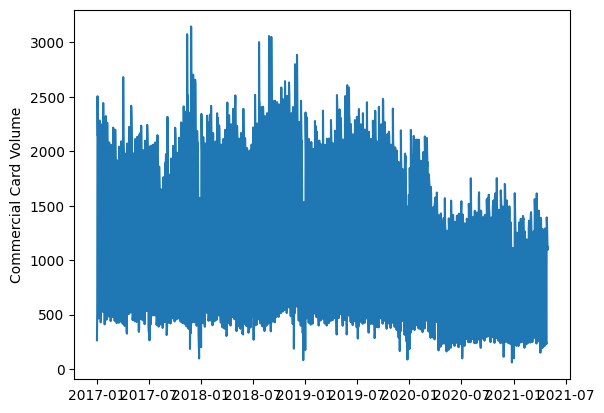

In [ ]:
# plotting commercial card call volume

x_values = [element[0] for element in corrected_data]
y_values = [element[1] for element in corrected_data]

plt.plot(x_values, y_values)
plt.ylabel('Commercial Card Volume')
plt.show()

Unfortunately, the data seems to reduce towards the end. This could negatively affect our training as we would train it on a relatively higher range of values, but expect the output to be in a much smaller range.

So we will take relatively larger training sets to have more accurate predictions

Let us now try to see if any reptitive patterns can be broken down from the data. Let us analyse the first 120 values

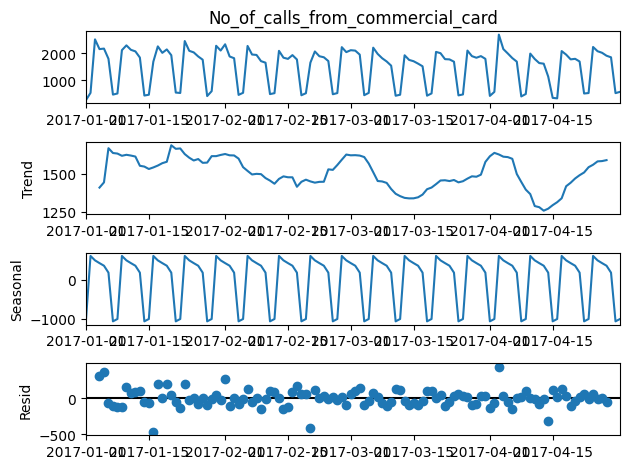

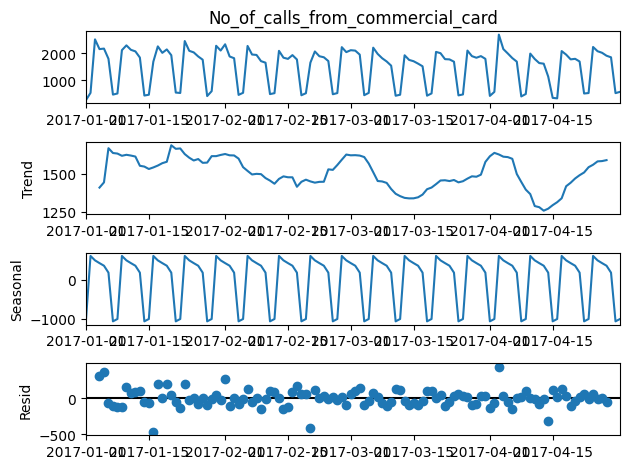

In [ ]:
#plotting for the first 120 values to see any repititive trend

newdf = pd.read_csv('Corrected_Commercial_Data.csv', index_col='Date', parse_dates=True)

results = seasonal_decompose(newdf['No_of_calls_from_commercial_card'][:120], model = 'additive')
results.plot()

Clearly the trend is extremely irregular so we clearly do not have any repititive behaviour in our data

## Predicting values from the data

Let us start by reading the CSV file where we stored all the accurate data

In [ ]:
maindf = pd.read_csv('Corrected_Data.csv', index_col='Date', parse_dates=True)

newdf = maindf
newdf

,No_of_calls_from_commercial_card,No_of_calls_from_retail_card,No_of_calls_from_student_card
Date,,,
2017-01-01,264.0,403.0,860.0
2017-01-02,528.0,792.0,1681.0
2017-01-03,2505.0,3774.0,7639.0
2017-01-04,2145.0,3236.0,6513.0
2017-01-05,2164.0,3265.0,6604.0
...,...,...,...
2021-04-26,1392.0,2094.0,4278.0
2021-04-27,1336.0,2014.0,4038.0
2021-04-28,1220.0,1831.0,3737.0


From the graph of trend of number of calls vs the date, one more thing that we can notice is that the number of calls drop drastically on the weekends, as compared to the weekdays. So let us number the days of the week according to the total number of calls that come in throughout the duration

In [ ]:
days = [(i%7) for i in range(1581)]

newdf['Commercial_Days'] = days
newdf['Retail_Days'] = days
newdf['Student_Days'] = days

list_days_com = [0,0,0,0,0,0,0]
list_days_ret = [0,0,0,0,0,0,0]
list_days_stu = [0,0,0,0,0,0,0]

for i in newdf.index:
    list_days_com[newdf['Commercial_Days'][i]]+=newdf['No_of_calls_from_commercial_card'][i]
    list_days_ret[newdf['Retail_Days'][i]]+=newdf['No_of_calls_from_retail_card'][i]
    list_days_stu[newdf['Student_Days'][i]]+=newdf['No_of_calls_from_student_card'][i]

count=0
for i in newdf.index:
    newdf['Commercial_Days'][i]=list_days_com[count%7]
    newdf['Retail_Days'][i]=list_days_ret[count%7]
    newdf['Student_Days'][i]=list_days_stu[count%7]
    count+=1

<ipython-input-13-ddb33c32b225>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['Commercial_Days'][i]=list_days_com[count%7]
<ipython-input-13-ddb33c32b225>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['Retail_Days'][i]=list_days_ret[count%7]
<ipython-input-13-ddb33c32b225>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['Student_Days'][i]=list_days_stu[count%7]


In [ ]:
newdf[:8]

,No_of_calls_from_commercial_card,No_of_calls_from_retail_card,No_of_calls_from_student_card,Commercial_Days,Retail_Days,Student_Days
Date,,,,,,
2017-01-01,264.0,403.0,860.0,88531,135072,281640
2017-01-02,528.0,792.0,1681.0,425170,639968,1291397
2017-01-03,2505.0,3774.0,7639.0,424392,638766,1287875
2017-01-04,2145.0,3236.0,6513.0,405112,609860,1231015
2017-01-05,2164.0,3265.0,6604.0,391126,589052,1189596
2017-01-06,1787.0,2697.0,5482.0,355613,535701,1082564
2017-01-07,464.0,715.0,1449.0,96966,147517,306137
2017-01-08,505.0,758.0,1574.0,88531,135072,281640


We have now marked every day of the week according to the total number of calls on that specific weekday, throughout the year

Let us now create the training set and the test set

Note that due to the reducing range of values as noticed from the graph above, the test set is small compared to the training set

In [ ]:
train = newdf[:1500]
test = newdf[1500:]
full = newdf

Let us now scale down the values to help the model train data easily

In [ ]:
scaler = MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)

scaler.fit(test)
scaled_test = scaler.transform(test)

scaler.fit(full)
scaled_full = scaler.transform(full)

We now need to select the number of inputs (window size). After experimenting with different values, 7 seems like an optimal window size as it is large enough to contain all the days of the week and can hence train the sudden drop on the weekends. A larger window size might not result in such accurate predictions

The time series generator hels us create out training examples

In [ ]:
n_input = 7
n_features = 6

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
X,y  = generator[0]
X.shape

(1, 7, 6)

Let us now build the model. Having experimented with various layers and number of neurons, this model seems to be a good fit for the data. I have trained it using the Adam Optimiser and the Mean_Squared_Error loss function

In [ ]:
model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (n_input,n_features), return_sequences = True))
model.add(LSTM(32, activation="relu", return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(6))
model.compile(optimizer="Adam", loss="mse")

Let us now train the model for 50 epochs as the values seem to converge after roughly 30-40 epochs

In [ ]:
model.fit(generator, epochs = 50)

Epoch 1/50
1493/1493 [==============================] - 19s 9ms/step - loss: 0.0461
Epoch 2/50
1493/1493 [==============================] - 14s 9ms/step - loss: 0.0148
Epoch 3/50
1493/1493 [==============================] - 13s 9ms/step - loss: 0.0115
Epoch 4/50
1493/1493 [==============================] - 14s 9ms/step - loss: 0.0104
Epoch 5/50
1493/1493 [==============================] - 14s 9ms/step - loss: 0.0092
Epoch 6/50
1493/1493 [==============================] - 14s 9ms/step - loss: 0.0087
Epoch 7/50
1493/1493 [==============================] - 14s 9ms/step - loss: 0.0084
Epoch 8/50
1493/1493 [==============================] - 14s 9ms/step - loss: 0.0083
Epoch 9/50
1493/1493 [==============================] - 14s 9ms/step - loss: 0.0081
Epoch 10/50
1493/1493 [==============================] - 14s 9ms/step - loss: 0.0077
Epoch 11/50
1493/1493 [==============================] - 15s 10ms/step - loss: 0.0078
Epoch 12/50
1493/1493 [==============================] - 14s 9ms/step - l

To see how well the model has been trained, let us plot the loss per epoch

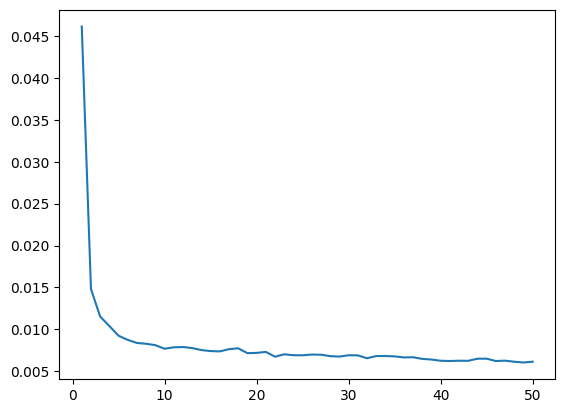

In [ ]:
loss_per_epoch = model.history.history["loss"]
x = [(i+1) for i in range (50)]
plt.plot(x,loss_per_epoch)

The values seem to converge after some time, so 50 epochs is enough

Let us now make predicitions for the next set of values to compare it with the training set

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(scaled_test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[scaled_test[i]]],axis=1)
    # current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


Since the values have been scaled down, wemust first get back our original values before we can calculate the score

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(scaled_test)

score = mean_absolute_percentage_error(y_test, true_predictions)
score

0.23379794866029888

Although the MAPE score is relatively high, it can be explained by the drop in values as we get to the later stages

Let us now predict the values to fill the initial CSV file (until 7/31/2021)

In [ ]:
#short term forecast
predictions = []

first_eval_batch = scaled_full[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(92):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


We can now see the predicted values

In [ ]:
true_predictions = scaler.inverse_transform(predictions)
true_predictions = pd.DataFrame(true_predictions).iloc[:,:3]
true_predictions

,0,1,2
0,328.793265,502.071151,1054.581582
1,283.008224,433.275122,917.668495
2,1551.589708,2337.178503,4745.002753
3,1584.891205,2387.299813,4838.852735
4,1541.529481,2322.545123,4704.192150
...,...,...,...
87,1762.180331,2653.429807,5364.484214
88,1688.147635,2542.638187,5137.925964
89,1659.580843,2499.930656,5049.156347
90,1506.694937,2270.586249,4596.474459


Let us append these values to the maindf dataframe

In [ ]:
final_df = corrected_df

In [ ]:
c = final_df.iloc[:-92,:].shape[0]

for i in range(92):

    final_df.iloc[c+i] = true_predictions.iloc[i]

final_df

,No_of_calls_from_commercial_card,No_of_calls_from_retail_card,No_of_calls_from_student_card
Date,,,
2017-01-01,264.000000,403.000000,860.000000
2017-01-02,528.000000,792.000000,1681.000000
2017-01-03,2505.000000,3774.000000,7639.000000
2017-01-04,2145.000000,3236.000000,6513.000000
2017-01-05,2164.000000,3265.000000,6604.000000
...,...,...,...
2021-07-27,1762.180331,2653.429807,5364.484214
2021-07-28,1688.147635,2542.638187,5137.925964
2021-07-29,1659.580843,2499.930656,5049.156347


Finally, we will store it in an excel file to conclude the project

In [ ]:
final_df.to_excel('Predicted_Values.xlsx')